In [4]:
# Directory and progress handling 
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

# Handle warnings
import warnings
warnings.filterwarnings('ignore')

# Data visulization
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# Text and Image proceesing and modeling
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v3  import preprocess_input
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, add, BatchNormalization, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split




In [5]:
!pip install --upgrade ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 

In [8]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working/'

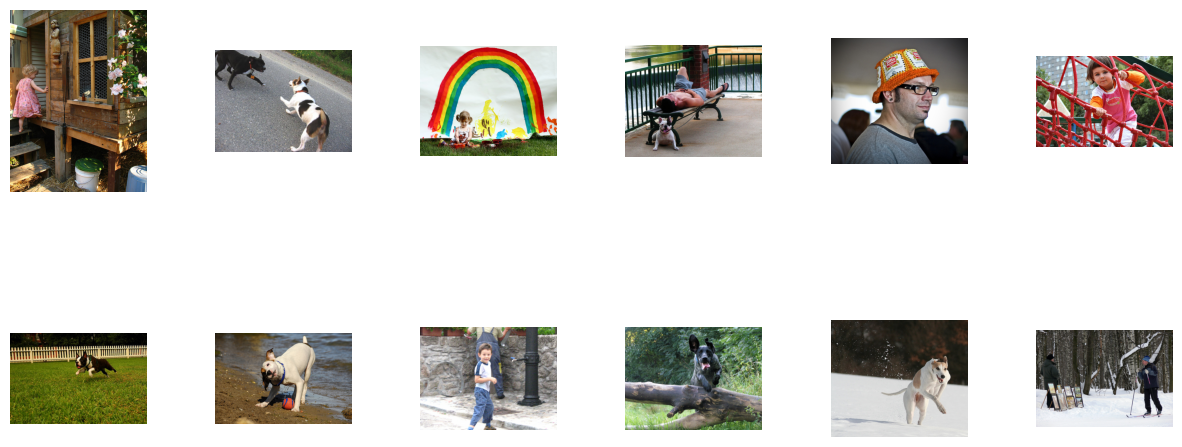

In [9]:


# Define the directory containing images
images_directory = os.path.join(BASE_DIR, 'Images')

# Retrieve the first 12 image filenames from the directory
image_files = sorted(os.listdir(images_directory))[:12]

# Create a figure with a grid layout for displaying images
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing

# Iterate over axes and corresponding image files to display them
for ax, image_file in zip(axes.flatten(), image_files):
    image_path = os.path.join(images_directory, image_file)
    with Image.open(image_path) as img:
        ax.imshow(img)
    ax.axis('off')  # Hide axes

# Show the plot with images
plt.show()

In [10]:
model = MobileNetV3Large(weights='imagenet', include_top=True)
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

22661472/22661472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:

# Initialize a dictionary to hold the features
features = {}

# Define the directory containing images
images_directory = os.path.join(BASE_DIR, 'Images')

# List all image filenames in the directory
image_filenames = os.listdir(images_directory)

# Process each image
for img_name in tqdm(image_filenames, desc="Extracting features"):
    img_path = os.path.join(images_directory, img_name)

    # Load and preprocess the image
    
    image = load_img(img_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    preprocessed_image = preprocess_input(image_array)

    # Extract features using the model
    feature = model.predict(preprocessed_image, verbose=0)

    # Extract the image ID from the filename
    image_id = os.path.splitext(img_name)[0]
    
    # Store the extracted features in the dictionary
    features[image_id] = feature

# Now 'features' dictionary contains the features for all images

Extracting features:   0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1732829171.749179     188 service.cc:145] XLA service 0x7c2a64001f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732829171.749235     188 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732829171.749241     188 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732829176.049718     188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:

# Define the path for the pickle file
features_file_path = os.path.join(WORKING_DIR, 'features.pkl')

# Save features to a pickle file using a context manager
with open(features_file_path, 'wb') as file:
    pickle.dump(features, file)

# Optionally, you can print a message confirming the save operation
print(f"Features have been successfully saved to {features_file_path}.")

Features have been successfully saved to /kaggle/working/features.pkl.


In [13]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    # to skip the first row on the captions file 
    next(f)
    # read all captions file
    captions_doc = f.read()

In [14]:
# Function to create a mapping of image IDs to captions
def create_caption_mapping(captions_doc):
    mapping = {}
    
    for line in tqdm(captions_doc.split('\n'), desc="Processing lines"):
        tokens = line.split(',')
        
        if len(tokens) < 2:
            continue
        
        image_id = tokens[0].split('.')[0]  # Remove extension
        caption = " ".join(tokens[1:])  # Join the rest as the caption
        
        # Initialize list if image ID is encountered for the first time
        mapping.setdefault(image_id, []).append(caption)
    
    return mapping

In [15]:
# Function to display images with their captions
def display_images_with_mapping(directory, mapping, num_images=6):
    img_names = os.listdir(directory)[:num_images]
    fig, axes = plt.subplots(num_images, 1, figsize=(10, num_images * 3))

    for i, img_name in enumerate(img_names):
        image_id = img_name.split('.')[0]
        
        if image_id in mapping:
            img_path = os.path.join(directory, img_name)
            img = plt.imread(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            
            # Get the first 5 captions
            captions = mapping[image_id][:5]
            axes[i].set_title("\n".join(captions), fontsize=12)

    plt.tight_layout()
    plt.show()

In [16]:
# Function to clean captions
def clean_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()  # Convert to lowercase
            caption = re.sub(r'[^A-Za-z\s]', '', caption)  # Remove non-alphabetic characters
            caption = re.sub(r'\s+', ' ', caption).strip()  # Remove extra spaces
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' <end>'
            captions[i] = caption

Processing lines:   0%|          | 0/40456 [00:00<?, ?it/s]

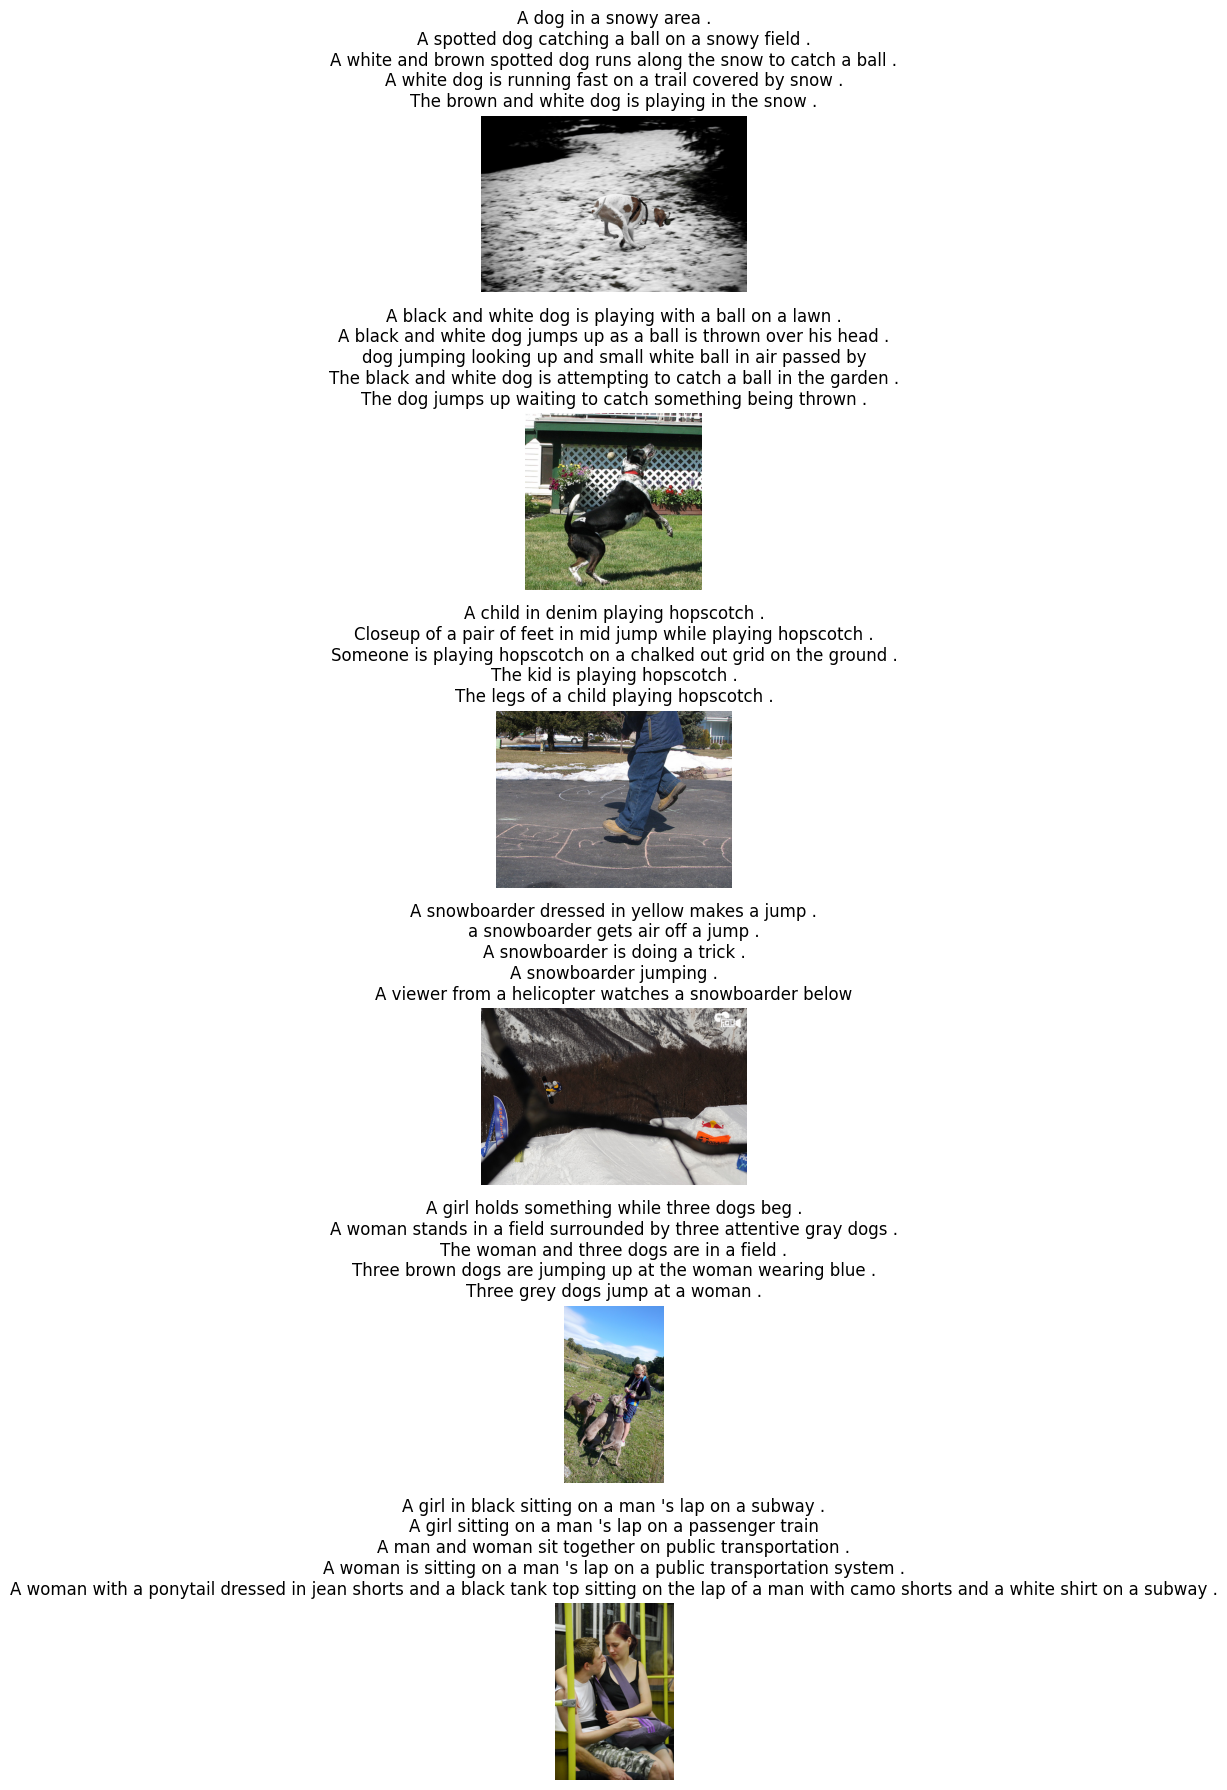

In [17]:
# create mapping
mapping = create_caption_mapping(captions_doc)

# Directory containing images
image_directory = os.path.join(BASE_DIR, 'Images')

# Display images with captions
display_images_with_mapping(image_directory, mapping)



In [18]:
print("before cleaning",mapping['1001773457_577c3a7d70'])
clean_captions(mapping)
print("_________________________________________________________________")
print("after cleaning",mapping['1001773457_577c3a7d70'])

before cleaning ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
_________________________________________________________________
after cleaning ['<start> black dog and spotted dog are fighting <end>', '<start> black dog and tricolored dog playing with each other on the road <end>', '<start> black dog and white dog with brown spots are staring at each other in the street <end>', '<start> two dogs of different breeds looking at each other on the road <end>', '<start> two dogs on pavement moving toward each other <end>']


In [19]:
# Extract captions from the mapping into a flat list
captions = [caption for captions_list in mapping.values() for caption in captions_list]

# Print the length of the captions list and the first five captions
print('Length of captions:', len(captions))
print('Captions:', captions[:5])

Length of captions: 40455
Captions: ['<start> child in pink dress is climbing up set of stairs in an entry way <end>', '<start> girl going into wooden building <end>', '<start> little girl climbing into wooden playhouse <end>', '<start> little girl climbing the stairs to her playhouse <end>', '<start> little girl in pink dress going into wooden cabin <end>']


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


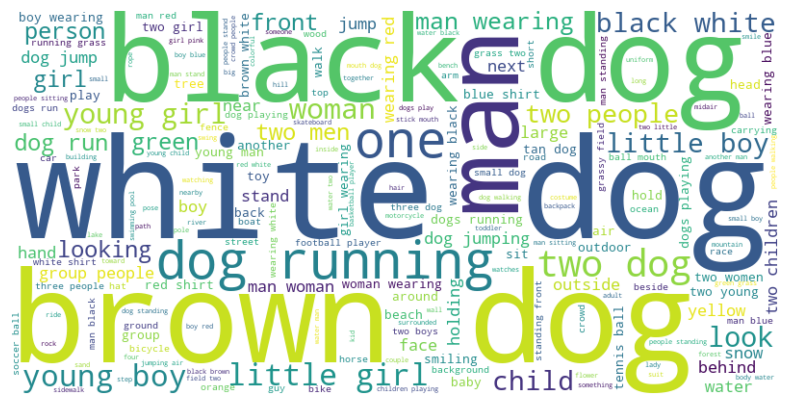

In [20]:

# Function to download NLTK stopwords
def download_stopwords():
    nltk.download('stopwords')

# Function to preprocess captions
def preprocess_captions(captions):
    # Remove '<start>' and '<end>' from captions
    return [caption.replace('<start>', '').replace('<end>', '') for caption in captions]

# Function to filter out stopwords from text
def filter_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return [word for word in text.split() if word not in stop_words]

# Function to create and display a word cloud
def create_word_cloud(words):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Main execution flow
download_stopwords()

# Assuming all_captions is already defined
filtered_captions = preprocess_captions(captions)
texts = " ".join(filtered_captions)
filtered_words = filter_stopwords(texts)

# Create and display the word cloud
create_word_cloud(filtered_words)

In [21]:


# Function to create and save a tokenizer
def create_and_save_tokenizer(captions, file_path):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    
    # Save the tokenizer to a file
    with open(file_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    
    return tokenizer


In [22]:

# Function to get vocabulary size
def get_vocab_size(tokenizer):
    return len(tokenizer.word_index) + 1

# Function to get maximum caption length
def get_max_caption_length(captions):
    return max(len(caption.split()) for caption in captions)


In [23]:

# Main execution flow
tokenizer_file_path = os.path.join(WORKING_DIR, 'tokenizer.pkl')
tokenizer = create_and_save_tokenizer(captions, tokenizer_file_path)
vocab_size = get_vocab_size(tokenizer)
max_length = get_max_caption_length(captions)

# Display results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_length)

Vocabulary Size: 8766
Maximum Caption Length: 34


In [24]:

# Prepare a list of image IDs
image_ids = list(mapping.keys())
def create_batch(X1, X2, y):
    """Helper function to create a batch from the collected data."""
    return {"image": np.array(X1), "text": np.array(X2)}, np.array(y)

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    """Generator function to yield batches of data for training."""
    X1, X2, y = [], [], []
    count = 0

    while True:
        for key in data_keys:
            captions = mapping.get(key, [])
            count += 1

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate input-output pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    # Pad input sequence and convert output to categorical
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append features and sequences to respective lists
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            # Yield a batch of data once the batch size is reached
            if count >= batch_size:
                yield create_batch(X1, X2, y)
                X1, X2, y = [], [], []  # Reset lists for the next batch
                count = 0


In [26]:
# Encoder Model
inputs1 = Input(shape=(1000,), name="image")
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(fe1)
fe2 = BatchNormalization()(fe2)

# Sequence Feature Layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = SimpleRNN(512, return_sequences=False)(se2)

# Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
decoder2 = Dropout(0.4)(decoder2)
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=5e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [27]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,              # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

In [28]:
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

In [ ]:
=


epochs = 35
batch_size = 32
steps_train = len(train_ids) // batch_size
steps_test = len(test_ids) // batch_size

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for i in range(epochs):
    print(f"Epoch {i + 1}")
    # create data generator
    train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    test_generator = data_generator(
        test_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size
    )
    # fit for one epoch
    history = model.fit(
        train_generator, epochs=1, steps_per_epoch=steps_train, verbose=1,  callbacks=[lr_scheduler, early_stopping], validation_data=test_generator,validation_steps=steps_test)
    # Save training metrics
    train_losses.append(history.history['loss'][-1])
    train_accuracies.append(history.history['accuracy'][-1])

    # Save validation metrics
    val_losses.append(history.history['val_loss'][-1])
    val_accuracies.append(history.history['val_accuracy'][-1])

Epoch 1
202/202 ━━━━━━━━━━━━━━━━━━━━ 66s 296ms/step - accuracy: 0.0927 - loss: 6.4646 - val_accuracy: 0.1562 - val_loss: 5.1049 - learning_rate: 5.0000e-04
Epoch 2
202/202 ━━━━━━━━━━━━━━━━━━━━ 59s 291ms/step - accuracy: 0.1702 - loss: 4.9450 - val_accuracy: 0.2354 - val_loss: 4.3802 - learning_rate: 5.0000e-04
Epoch 3
202/202 ━━━━━━━━━━━━━━━━━━━━ 59s 293ms/step - accuracy: 0.2361 - loss: 4.2586 - val_accuracy: 0.2695 - val_loss: 4.0860 - learning_rate: 5.0000e-04
Epoch 4
202/202 ━━━━━━━━━━━━━━━━━━━━ 58s 288ms/step - accuracy: 0.2652 - loss: 3.9285 - val_accuracy: 0.2832 - val_loss: 3.9529 - learning_rate: 5.0000e-04
Epoch 5
202/202 ━━━━━━━━━━━━━━━━━━━━ 59s 291ms/step - accuracy: 0.2805 - loss: 3.7217 - val_accuracy: 0.2945 - val_loss: 3.8709 - learning_rate: 5.0000e-04
Epoch 6
202/202 ━━━━━━━━━━━━━━━━━━━━ 58s 289ms/step - accuracy: 0.2926 - loss: 3.5583 - val_accuracy: 0.3016 - val_loss: 3.8215 - learning_rate: 5.0000e-04
Epoch 7
202/202 ━━━━━━━━━━━━━━━━━━━━ 58s 289ms/step - accuracy: 

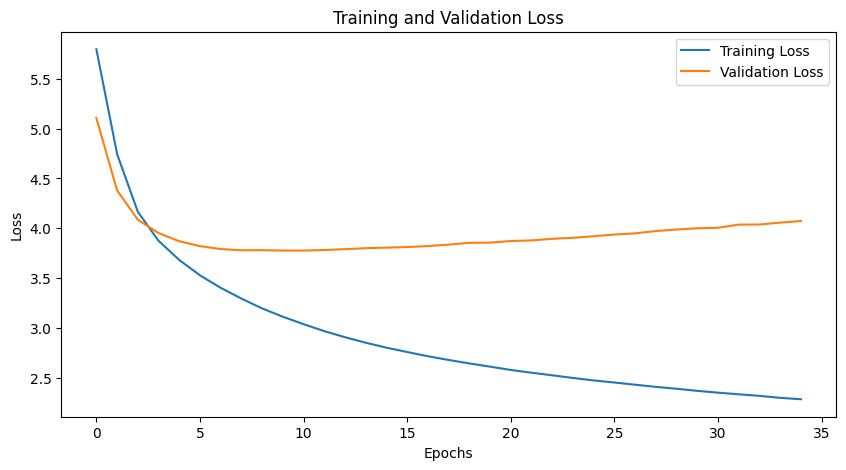

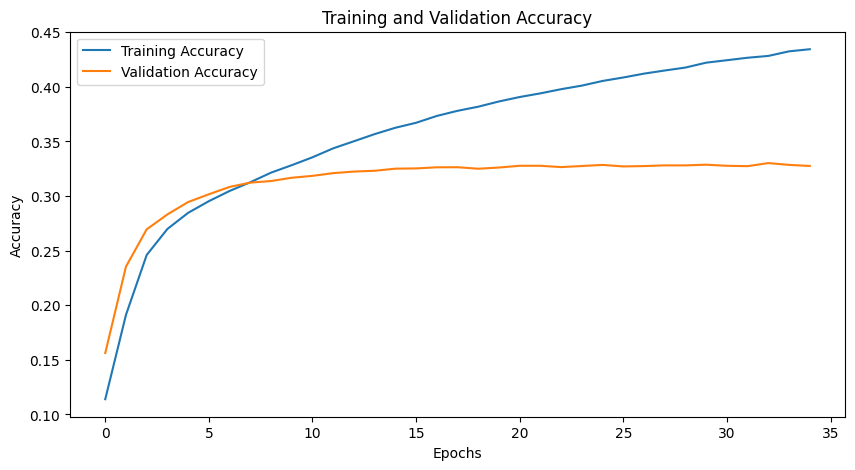

In [30]:

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [53]:
def predict_caption(model, image, tokenizer, max_length):
    """Generate a caption for a given image using the specified model and tokenizer."""
    # Initialize input text with the start tag
    in_text = '<start>'
    
    for _ in range(max_length):
        # Encode and pad the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        padded_sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict the next word
        predictions = model.predict([image, padded_sequence], verbose=0)
        predicted_index = np.argmax(predictions)

        # Convert index to word
        word = idx_to_word(predicted_index, tokenizer)
        
        # Stop if the predicted word is not found
        if word is None:
            break
        
        # Append the predicted word to the input text
        in_text += " " + word

        # Stop if the end tag is predicted
        if word == '<end>':
            break

    return in_text.strip()  # Return the generated caption, stripped of any leading/trailing whitespace

In [32]:
def idx_to_word(integer, tokenizer):
    """Convert an integer index to its corresponding word using the tokenizer."""
    return tokenizer.index_word.get(integer, None)

In [31]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name, ):

    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name+".jpg")
    image = Image.open(img_path)

    # Display actual captions
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Show the image
    plt.imshow(image)

---------------------Actual---------------------
<start> one football player wearing an orange jersey and one wearing white jersey are set at the starting line <end>
<start> two college football players about to face off <end>
<start> two football players are getting ready to tackle each other <end>
<start> two football players one in an orange jersey and one in white jersey play on the field <end>
<start> two rival football players head to head <end>
--------------------Predicted--------------------
<start> football player in red uniform is tackled by player in red and white uniform end end end end end end end waiting end end end waiting for football game end end end waiting football


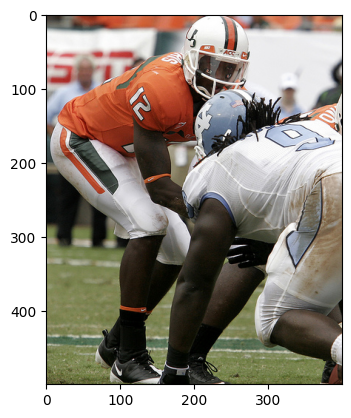

In [51]:
import random
generate_caption(random.choice(test_ids))

---------------------Actual---------------------
<start> group of people sit in lawn chairs at the edge of large cliff <end>
<start> people in folding chairs take in the view from cliff <end>
<start> people sitting on chairs overlooking steep rocky incline <end>
<start> several people sit in chairs near canyon <end>
<start> several people sitting on foldable chairs near geological formation <end>
--------------------Predicted--------------------
<start> hiker is sitting on top of mountain end end on the top of mountain end end end overlooking the mountains end end end end end of boulders end of mountain end end of mountain


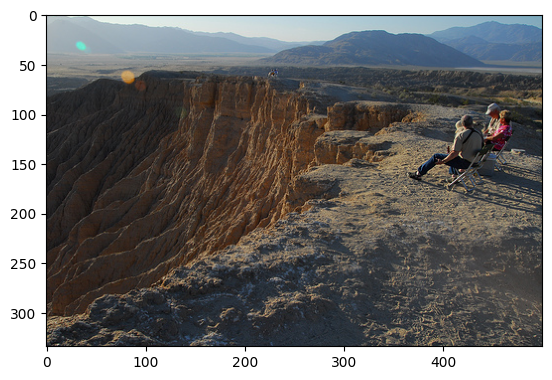

In [34]:
import random
generate_caption(random.choice(test_ids))

---------------------Actual---------------------
<start> black dog is walking along the side of pool <end>
<start> black dog runs around an outdoor swimming pool <end>
<start> black dog walking beside pool <end>
<start> black poodle walks on the edge of pool <end>
<start> fluffy blank poodle is walking on the edge of pool <end>
--------------------Predicted--------------------
<start> black dog is running on the grass end of the snow end end bared end bared end bared end bared end bared end bared end bared end bared end bared end hurdle hurdle end


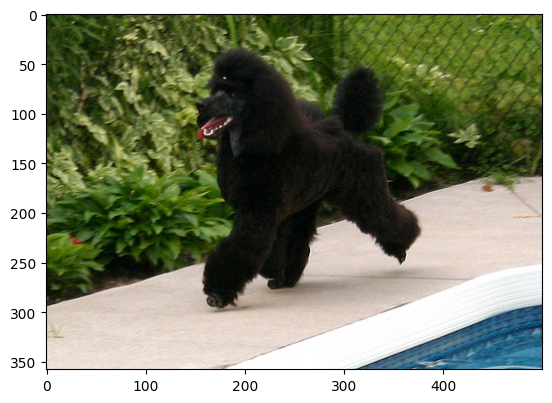

In [50]:
import random
generate_caption(random.choice(test_ids))

---------------------Actual---------------------
<start> flag is carried <end>
<start> red white black and green flag <end>
<start> the flag of country is being held in crowd <end>
<start> there is hand in front of red green white and black flag <end>
<start> there is picture of green white black and red flag <end>
--------------------Predicted--------------------
<start> boy in red shirt and red shirt is raising his head in crowd of people end end end of fabric end of fabric end end of fabric end of beer end of fabric end


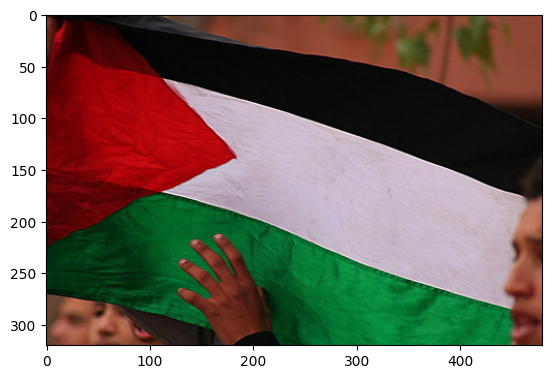

In [32]:
import random
generate_caption(random.choice(test_ids))

In [47]:
model.save('model3.keras')

In [45]:

def evaluate_bleu(model, tokenizer, images, ground_truth_captions, features, max_length):
    actual, predicted = list(), list()

    for img_name in images:
        # Generate caption for the image
        image_feature = features[img_name]  # Load image features
        predicted_caption = predict_caption(model, image_feature, tokenizer, max_length)
        
        # Collect the ground truth captions for evaluation
        actual_captions = ground_truth_captions[img_name]  # List of ground truth captions
        actual.append([caption.split() for caption in actual_captions])  # List of lists of words
        predicted.append(predicted_caption.split())  # List of words for predicted caption

    # Compute BLEU score
    bleu_score_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))  # BLEU-1
    bleu_score_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))  # BLEU-2
    print("BLEU-1: %f" % bleu_score_1)
    print("BLEU-2: %f" % bleu_score_2)

    return bleu_score_1, bleu_score_2

# Example usage - evaluate only on the first 3 images
first_three_images = test_ids[:3]  # Get the first 3 images
bleu_score_1, bleu_score_2 = evaluate_bleu(model, tokenizer, images=first_three_images, ground_truth_captions=mapping, features=features, max_length=max_length)

BLEU-1: 0.228571
BLEU-2: 0.133892


In [49]:
import numpy as np
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu(model, tokenizer, images, ground_truth_captions, features, max_length, batch_size=32):
    actual, predicted = [], []

    # Preprocess ground truth captions
    for img_name in images:
        actual_captions = ground_truth_captions[img_name]
        actual.append([caption.split() for caption in actual_captions])

    # Process images in batches
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        batch_features = [features[img_name] for img_name in batch_images]

        # Generate captions for the batch
        predicted_captions = model_predict_batch(model, batch_features, tokenizer, max_length)

        # Append predicted captions
        predicted.extend(predicted_captions)

    # Compute BLEU score
    bleu_score_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))  # BLEU-1
    bleu_score_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))  # BLEU-2
    print("BLEU-1: %f" % bleu_score_1)
    print("BLEU-2: %f" % bleu_score_2)

    return bleu_score_1, bleu_score_2

def model_predict_batch(model, batch_features, tokenizer, max_length):
    # This function should handle the generation of captions for a batch of features
    predicted_captions = []
    for image_feature in batch_features:
        predicted_caption = predict_caption(model, image_feature, tokenizer, max_length)
        predicted_captions.append(predicted_caption.split())  # Store as list of words
    return predicted_captions

# Example usage
bleu_score_1, bleu_score_2 = evaluate_bleu(model, tokenizer, images=test_ids, ground_truth_captions=mapping, features=features, max_length=max_length)

BLEU-1: 0.187788
BLEU-2: 0.110821


In [54]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model

# Define the video file path (ensure you upload the video to Kaggle)
video_path = '/kaggle/input/dogvideo/IMG_7294.MOV'
output_video_path = '/kaggle/working/output_with_captions33.avi'

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Cannot open video file.")

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define VideoWriter to save output video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Load MobileNetV3 feature extractor
model2 = MobileNetV3Large(weights='imagenet', include_top=True)
model2 = Model(inputs=model2.inputs, outputs=model2.layers[-2].output)

# Function to extract features
def extract_features(image):
    if len(image.shape) != 4 or image.shape[-1] != 3:
        raise ValueError("Input image must have shape (1, 224, 224, 3).")
    preprocessed_image = preprocess_input(image)
    feature = model2.predict(preprocessed_image, verbose=0)
    return feature



# Video processing loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop if no more frames

    # Resize frame to (224, 224) for MobileNetV3
    resized_frame = cv2.resize(frame, (224, 224))
    
    # Convert BGR to RGB
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    
    # Preprocess frame for feature extraction
    frame_array = img_to_array(rgb_frame)
    frame_array = np.expand_dims(frame_array, axis=0)

    # Extract features using MobileNetV3
    frame_features = extract_features(frame_array)
    
    # Generate caption for the frame
    caption = predict_caption(model, frame_features, tokenizer, max_length)

    # Overlay caption on the original frame
    cv2.putText(frame, caption, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Write the frame to the output video
    out.write(frame)

# Release resources
cap.release()
out.release()

print(f"Video with captions saved to {output_video_path}")


Video with captions saved to /kaggle/working/output_with_captions33.avi


In [55]:
import cv2
import os

# Define the video file path
video_path = '/kaggle/working/output_with_captions33.avi'

# Define the output folder for frames
output_folder = '/kaggle/working/frames'
os.makedirs(output_folder, exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Cannot open video file.")

# Frame extraction loop
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop if no more frames

    # Save the current frame as an image file
    frame_filename = os.path.join(output_folder, f'frame_{frame_count:05d}.jpg')
    cv2.imwrite(frame_filename, frame)
    frame_count += 1

# Release the video capture
cap.release()

print(f"Frames saved to folder: {output_folder}")
print(f"Total frames extracted: {frame_count}")


Frames saved to folder: /kaggle/working/frames
Total frames extracted: 145


In [ ]:


# Main function to capture video and generate captions
def live_captioning(model, tokenizer, max_length, target_size=(224, 224)):
    """Capture live video and generate captions in real-time."""
    # Initialize video capture
    cap = cv2.VideoCapture(0)  # 0 for the default camera

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image")
            break
        # Resize frame to (224, 224) for MobileNetV3
        resized_frame = cv2.resize(frame, (224, 224))
        
        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
        
        # Preprocess frame for feature extraction
        frame_array = img_to_array(rgb_frame)
        frame_array = np.expand_dims(frame_array, axis=0)
    
        # Extract features using MobileNetV3
        frame_features = extract_features(frame_array)
        
        # Generate caption for the frame
        caption = predict_caption(model, frame_features, tokenizer, max_length)
    
        # Overlay caption on the original frame
        cv2.putText(frame, caption, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

       
        # Display the resulting frame
        cv2.imshow('Live Captioning', frame)

        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

# Example usage
live_captioning(model, tokenizer, max_length)